In [1]:
from datetime import datetime

import numpy as np
import torch
from gym.wrappers import (
    FilterObservation,
    FlattenObservation,
    FrameStack,
    RecordVideo,
    RescaleAction,
    TimeLimit,
)
from stable_baselines3.common.env_util import unwrap_wrapper

from bayesopt import calculate_objective, get_new_bound, get_next_samples, scale_action
from ea_optimize import (
    ARESEADOOCS,
    ARESEAeLog,
    BaseCallback,
    CallbackList,
    OptimizeFunctionCallback,
    setup_callback,
)
from utils import (
    FilterAction,
    NotVecNormalize,
    PolishedDonkeyCompatibility,
    RecordEpisode,
    send_to_elog,
)


initializing ocelot...


## Preamble

Remarks: I would set a higher max_step for BO, maybe 100/150?

In [2]:
config = config = {
    "action_mode": "direct_unidirectional_quads",
    "gamma": 0.99,
    # "filter_action": [0, 1, 3],
    "filter_action": None,
    "filter_observation": None,
    "frame_stack": None,
    "incoming_mode": "random",
    "incoming_values": None,
    "magnet_init_mode": "constant",
    "magnet_init_values": np.array([10, -10, 0, 10, 0]),
    "misalignment_mode": "constant",
    "misalignment_values": np.zeros(8),
    "n_envs": 40,
    "normalize_observation": True,
    "normalize_reward": True,
    "rescale_action": (-3, 3),
    "reward_mode": "logl1",
    "sb3_device": "auto",
    "target_beam_mode": "constant",
    "target_beam_values": np.zeros(4),
    "target_mu_x_threshold": 1e-5,
    "target_mu_y_threshold": 1e-5,
    "target_sigma_x_threshold": 1e-5,
    "target_sigma_y_threshold": 1e-5,
    "threshold_hold": 5,
    "time_limit": 50000,
    "vec_env": "subproc",
    "w_done": 0.0,
    "w_mu_x": 1.0,
    "w_mu_x_in_threshold": 0.0,
    "w_mu_y": 1.0,
    "w_mu_y_in_threshold": 0.0,
    "w_on_screen": 100.0,
    "w_sigma_x": 1.0,
    "w_sigma_x_in_threshold": 0.0,
    "w_sigma_y": 1.0,
    "w_sigma_y_in_threshold": 0.0,
    "w_time": 0.0,
}


In [3]:
# define a similar optimize function as in ea_optimize.py


def optimize(
    target_mu_x,
    target_sigma_x,
    target_mu_y,
    target_sigma_y,
    target_mu_x_threshold=3.3198e-6,
    target_mu_y_threshold=3.3198e-6,
    target_sigma_x_threshold=3.3198e-6,
    target_sigma_y_threshold=3.3198e-6,
    max_steps=100,
    model_name="BO",
    logbook=False,
    data_log_dir=None,
    callback=BaseCallback(),
    stepsize=0.1,  # comparable to RL env
    obj_function="logmae",
    acquisition="EI",
    init_x=None,
    init_samples=5,
    filter_action=None,
    set_to_best=True,  # set back to best found setting after opt.
):
    callback = setup_callback(callback)

    # Create the environment
    env = ARESEADOOCS(
        action_mode=config["action_mode"],
        magnet_init_mode=config["magnet_init_mode"],
        magnet_init_values=config["magnet_init_values"],
        reward_mode=config["reward_mode"],
        target_beam_mode=config["target_beam_mode"],
        target_beam_values=np.array(
            [target_mu_x, target_sigma_x, target_mu_y, target_sigma_y]
        ),
        target_mu_x_threshold=target_mu_x_threshold,
        target_mu_y_threshold=target_mu_y_threshold,
        target_sigma_x_threshold=target_sigma_x_threshold,
        target_sigma_y_threshold=target_sigma_y_threshold,
        threshold_hold=1,
        w_done=config["w_done"],
        w_mu_x=config["w_mu_x"],
        w_mu_x_in_threshold=config["w_mu_x_in_threshold"],
        w_mu_y=config["w_mu_y"],
        w_mu_y_in_threshold=config["w_mu_y_in_threshold"],
        w_on_screen=config["w_on_screen"],
        w_sigma_x=config["w_sigma_x"],
        w_sigma_x_in_threshold=config["w_sigma_x_in_threshold"],
        w_sigma_y=config["w_sigma_y"],
        w_sigma_y_in_threshold=config["w_sigma_y_in_threshold"],
        w_time=config["w_time"],
    )
    if max_steps is not None:
        env = TimeLimit(env, max_steps)
    if callback is not None:
        env = OptimizeFunctionCallback(env, callback)
    if data_log_dir is not None:
        env = RecordEpisode(env, save_dir=data_log_dir)
    if logbook:
        env = ARESEAeLog(env, model_name=model_name)
    if config["filter_observation"] is not None:
        env = FilterObservation(env, config["filter_observation"])
    if config["filter_action"] is not None:
        env = FilterAction(env, config["filter_action"], replace=0)
    env = FlattenObservation(env)
    if config["frame_stack"] is not None:
        env = FrameStack(env, config["frame_stack"])
    if config["rescale_action"] is not None:
        env = RescaleAction(
            env, config["rescale_action"][0], config["rescale_action"][1]
        )
    env = RecordVideo(env, video_folder=f"recordings_real/{datetime.now():%Y%m%d%H%M}")
    # env = NotVecNormalize(env, f"models/{model_name}/vec_normalize.pkl")

    callback.env = env

    # Actual optimisation
    observation = env.reset()
    done = False

    # Initialization
    x_dim = env.action_space.shape[0]
    # bounds = torch.tensor(
    #     np.array([env.action_space.low, env.action_space.high]), dtype=torch.float32
    # )
    if init_x is not None:  # From fix starting points
        X = torch.tensor(init_x.reshape(-1, x_dim), dtype=torch.float32)
    else:  # Random Initialization-5.7934
        action_i = scale_action(env, observation, filter_action)
        X = torch.tensor([action_i], dtype=torch.float32)
        bounds = get_new_bound(env, action_i, stepsize)
        for i in range(init_samples - 1):
            new_action = np.random.uniform(low=bounds[0], high=bounds[1])
            X = torch.cat([X, torch.tensor([new_action])])
    # Sample initial Ys to build GP
    Y = torch.empty((X.shape[0], 1))
    for i, action in enumerate(X):
        action = action.detach().numpy()
        print(f"Collecting initial Ys step {i} at {action = }")
        observation, reward, done, info = env.step(action)
        print(f"{reward = }")
        objective = calculate_objective(env, observation, reward, obj=obj_function)
        Y[i] = torch.tensor(objective)

    # Actual BO Loop
    jans_i = 0
    while not done:
        current_action = X[-1].detach().numpy()
        bounds = get_new_bound(env, current_action, stepsize)
        action_t = get_next_samples(
            X,
            Y,
            Y.max(),
            torch.tensor(bounds, dtype=torch.float32),
            n_points=1,
            acquisition=acquisition,
        )
        action = action_t.detach().numpy().flatten()
        print(f"Actual optimisation exploring step {jans_i} {action = }")
        jans_i += 1
        observation, reward, done, info = env.step(action)
        print(f"{reward = }")
        objective = calculate_objective(env, observation, reward, obj=obj_function)

        # append data
        X = torch.cat([X, action_t])
        Y = torch.cat([Y, torch.tensor([[objective]], dtype=torch.float32)])

    # Set back to
    if set_to_best:
        action = X[Y.argmax()].detach().numpy()
        observation, reward, done, info = env.step(action)

    env.close()


## Actual BO

/var/folders/z8/vzg_1dr50gg1zchydp1styc00000gn/T/ipykernel_80378/3139921690.py:96: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  X = torch.cat([X, torch.tensor([new_action])])


reward = -69.86980326080439
reward = -67.31644122373916
reward = -70.78936790090812
reward = -71.46704548328746
reward = -67.1421973593327
Actual optimisation exploring step 0 action = array([-2.5346947 ,  1.8929689 ,  0.22475342, -2.2841    ,  0.04561733],
      dtype=float32)
reward = -68.33685426782763
Actual optimisation exploring step 1 action = array([-2.3939807 ,  2.0789998 ,  0.20182599, -2.4953797 ,  0.14597034],
      dtype=float32)
reward = -68.08243593598486
Actual optimisation exploring step 2 action = array([-2.332998  ,  1.9065448 ,  0.10452656, -2.3758495 ,  0.18949403],
      dtype=float32)
reward = -66.3459496751868
Actual optimisation exploring step 3 action = array([-2.3305469 ,  1.803545  , -0.00510421, -2.4324226 ,  0.24209622],
      dtype=float32)
reward = -64.37644901551839
Actual optimisation exploring step 4 action = array([-2.3308022 ,  1.6783372 , -0.09666394, -2.4621243 ,  0.34222496],
      dtype=float32)
reward = -66.42434995377565


/usr/bin/lp: No such file or directory


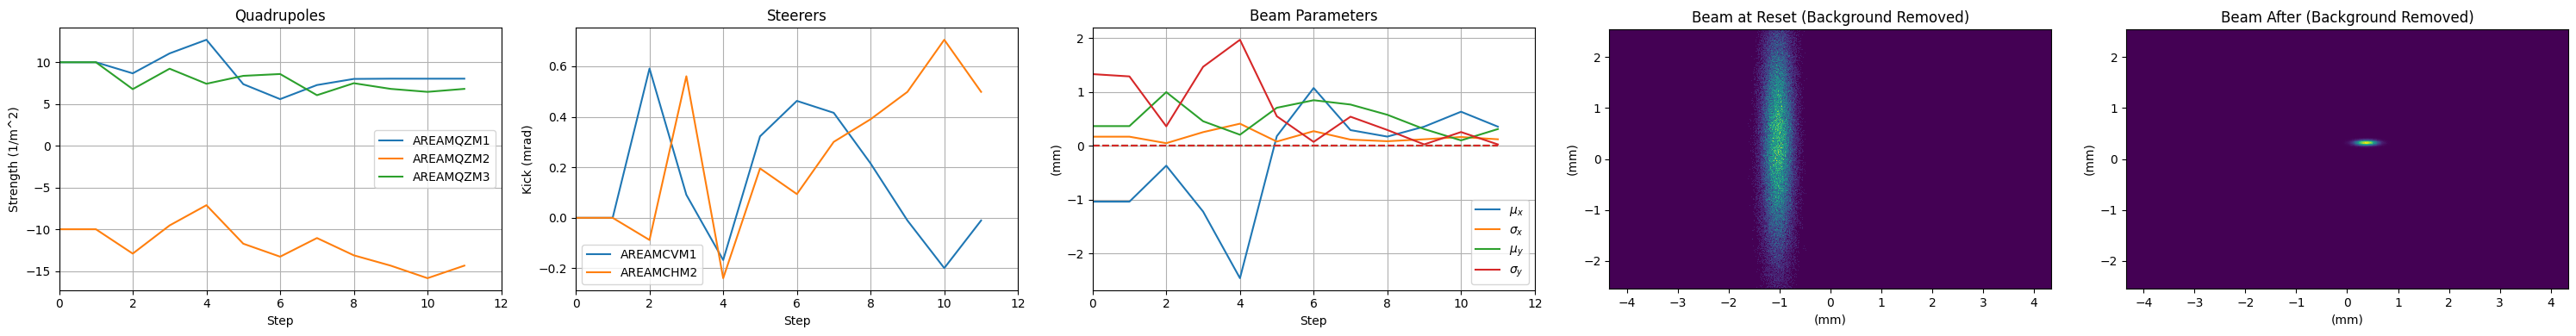

In [5]:
# hopefully this would run :)

optimize(
    target_mu_x=0.0,  # 0.4249e-3,
    target_sigma_x=0.0,
    target_mu_y=0.0,  # 1.1048e-3,
    target_sigma_y=0.0,
    target_mu_x_threshold=3.16e-6,
    target_mu_y_threshold=3.16e-6,
    target_sigma_x_threshold=3.16e-6,
    target_sigma_y_threshold=3.16e-6,
    max_steps=10,
    model_name="BO",
    logbook=True,
    data_log_dir="data_recordings_bo",
    callback=None,
    obj_function="logmae",
    acquisition="EI",
    init_x=None,
    init_samples=5,
    filter_action=None,
)


In [ ]:
# hopefully this would run :)

# optimize(
#     target_mu_x=0.4249e-3,
#     target_sigma_x=0.0,
#     target_mu_y=1.1048e-3,
#     target_sigma_y=0.0,
#     target_mu_x_threshold=3.16e-6,
#     target_mu_y_threshold=3.16e-6,
#     target_sigma_x_threshold=3.16e-6,
#     target_sigma_y_threshold=3.16e-6,
#     max_steps=100,
#     model_name="BO",
#     logbook=True,
#     callback=None,
#     obj_function='logmae',
#     acquisition="EI",
#     init_x = None,
#     init_samples = 5,
#     filter_action = None,
# )
